In [14]:
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

In [15]:
auth = earthaccess.login()

In [16]:
collection_short_name = "MUR25-JPL-L4-GLOB-v04.2"
time_range = ("2024-03-05", "2025-07-01")
bbox = (-100, -60, 20, 70)

# Search granules
results = earthaccess.search_data(
    short_name=collection_short_name,
    temporal=time_range,
    bounding_box=bbox
)

print(f"Found {len(results)} granules")

Found 485 granules


In [17]:
ghrsst = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/485 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/485 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/485 [00:00<?, ?it/s]

In [18]:
# Single image
ds = xr.open_dataset(
    ghrsst[0],
    engine="h5netcdf",
    drop_variables=["mask", "sea_ice_fraction", "dt_1km_data", "sst_anomaly", "analysis_error"]
)
print(ds)

<xarray.Dataset> Size: 8MB
Dimensions:       (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time          (time) datetime64[ns] 8B 2024-03-05T09:00:00
  * lat           (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    analysed_sst  (time, lat, lon) float64 8MB ...
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      Daily 0.25-degree MUR SST, Final product
    summary:                    A low-resolution version of the MUR SST analy...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              https://www.ghrsst.org
    publishe

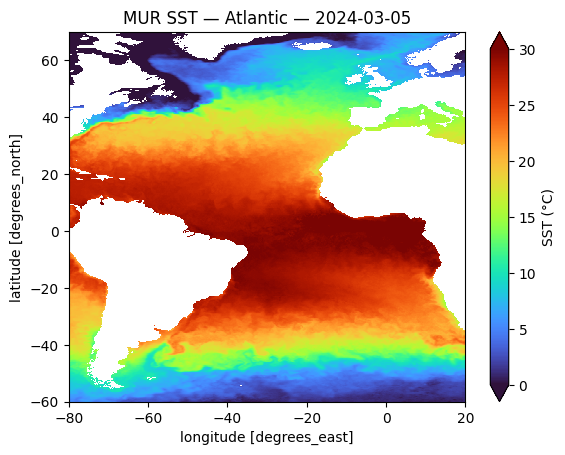

In [19]:
#Single image plot
sst = ds['analysed_sst'].isel(time=0).sel(lat=slice(-60, 70), lon=slice(-80, 20)) - 273.15

# Plot SST
sst.plot(cmap="turbo", cbar_kwargs={'label': 'SST (°C)'}, vmin=0, vmax=30)
plt.title(f"MUR SST — Atlantic — {str(sst.time.values)[:10]}")
plt.show()

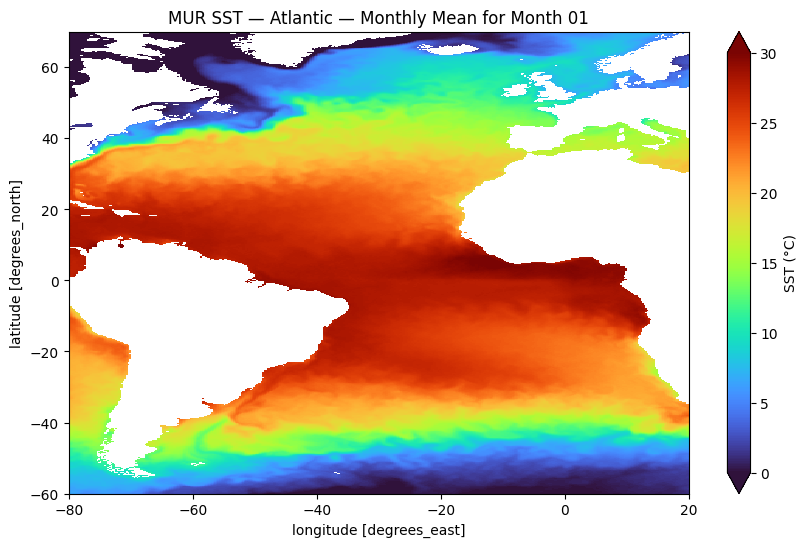

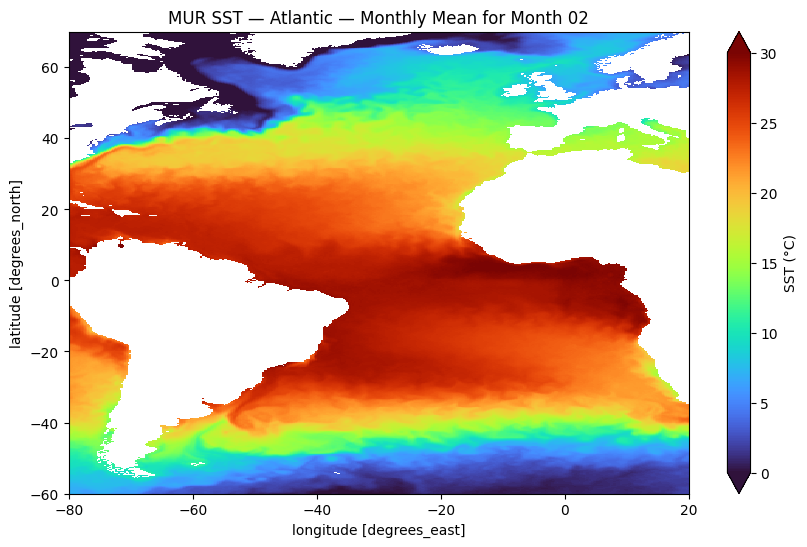

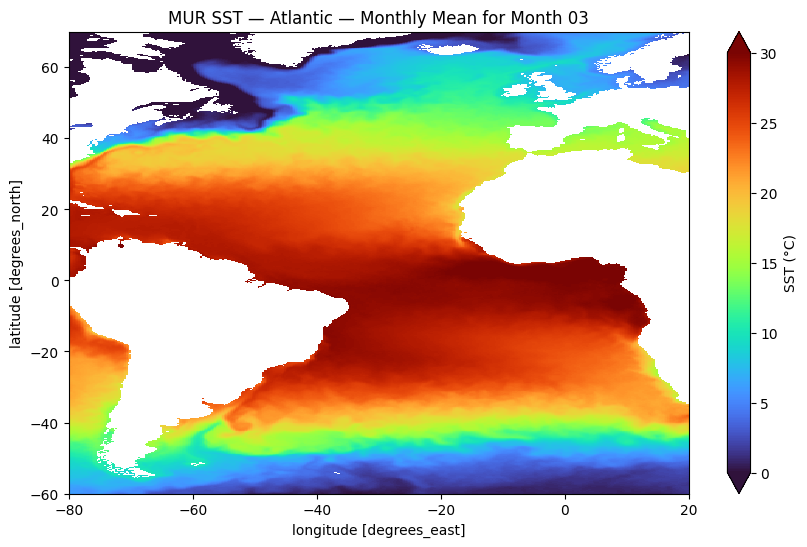

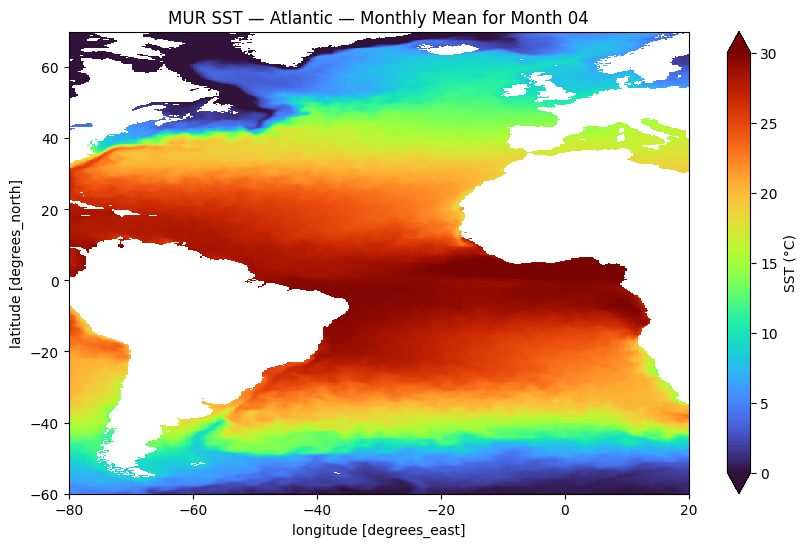

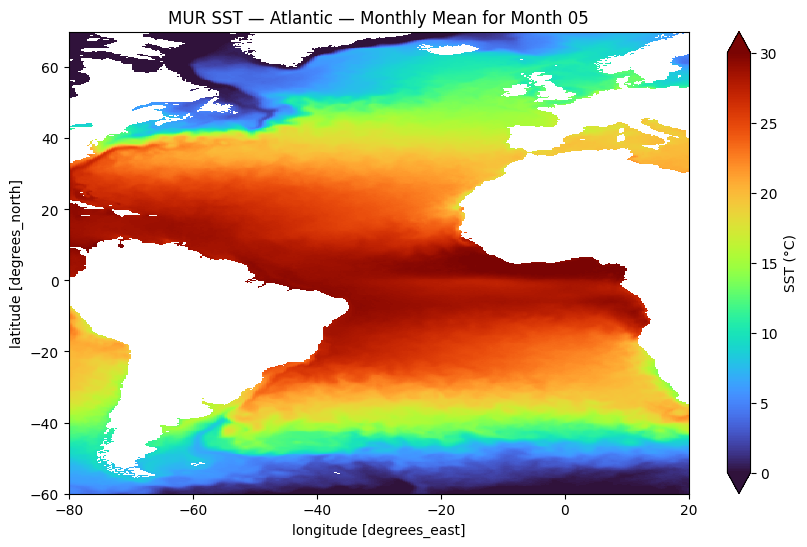

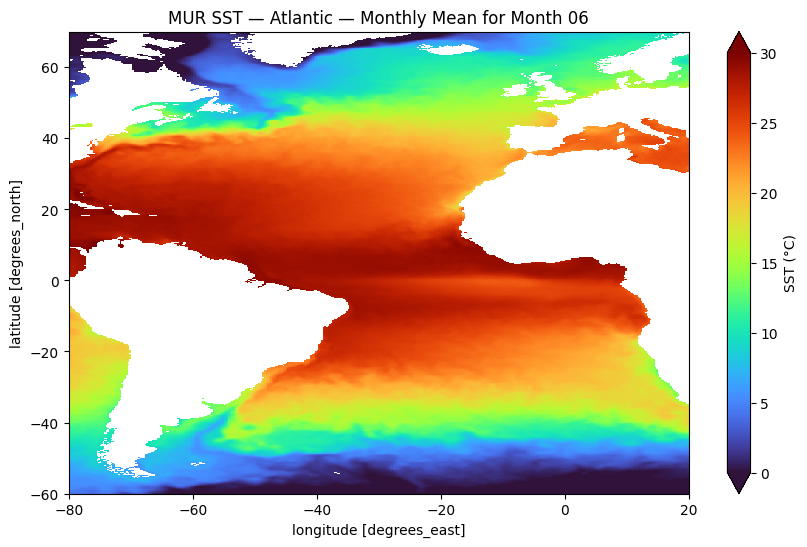

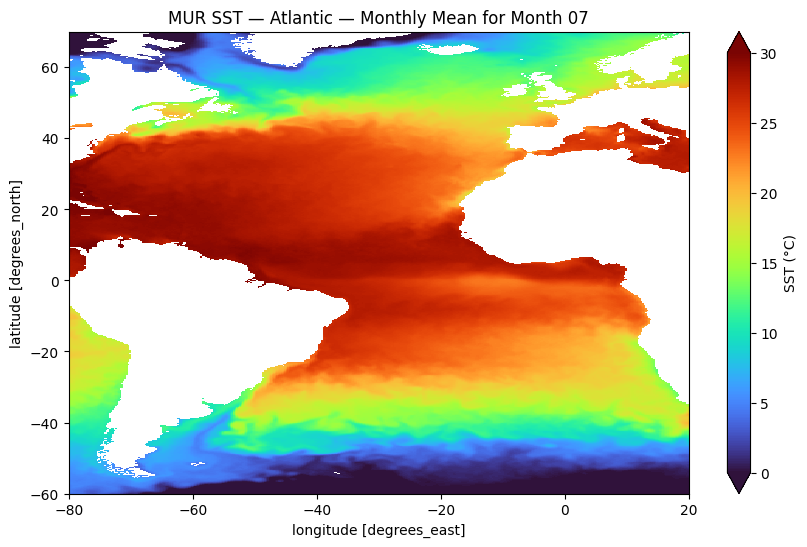

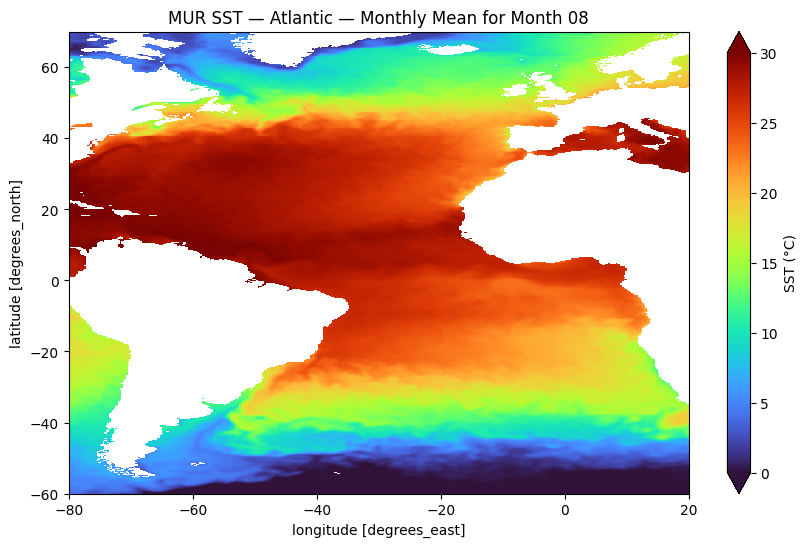

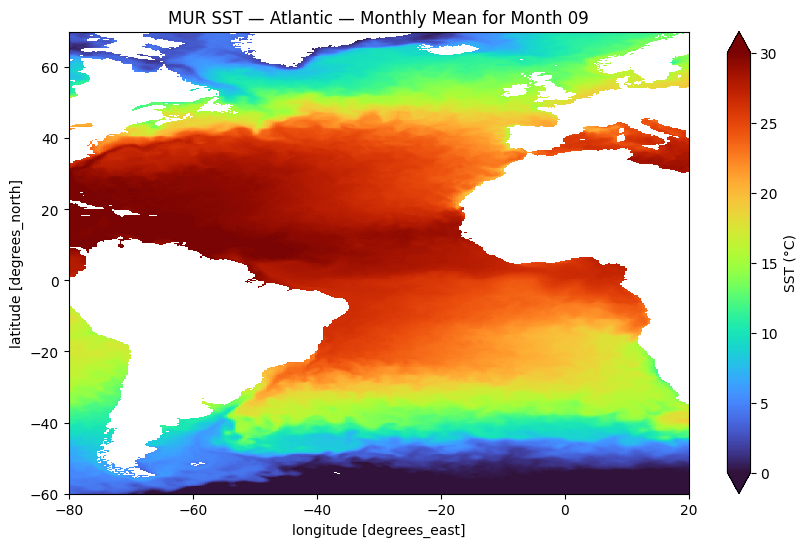

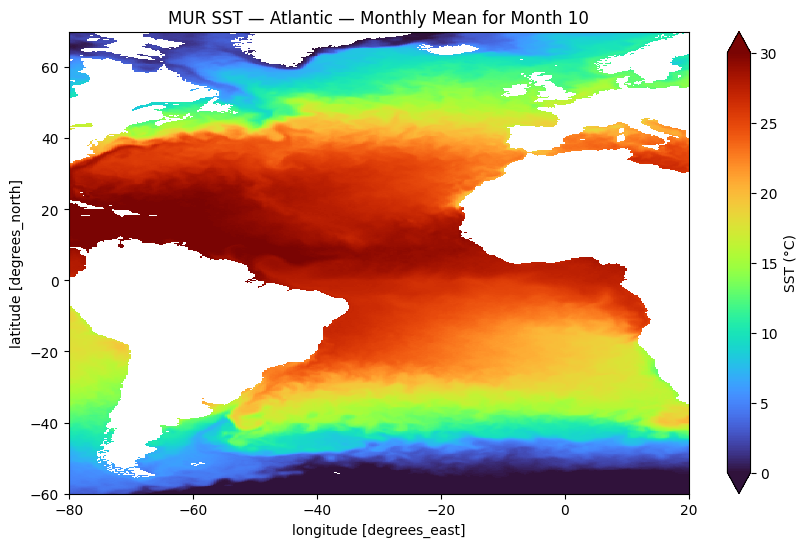

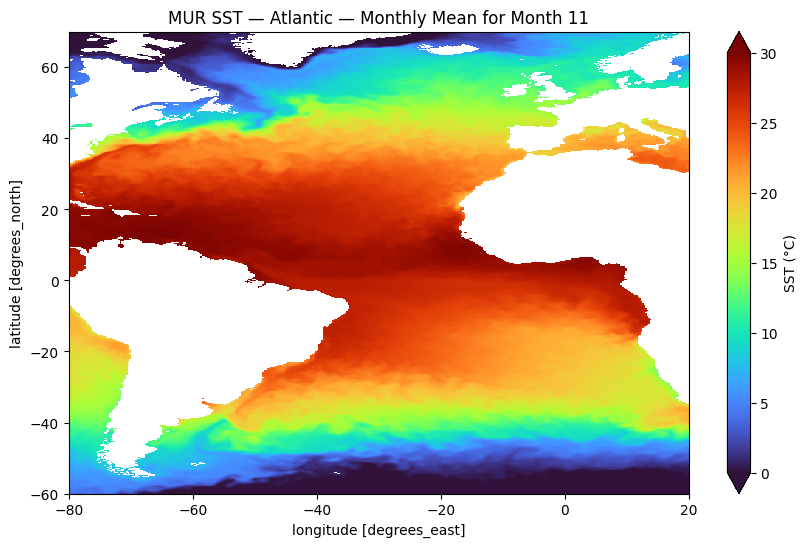

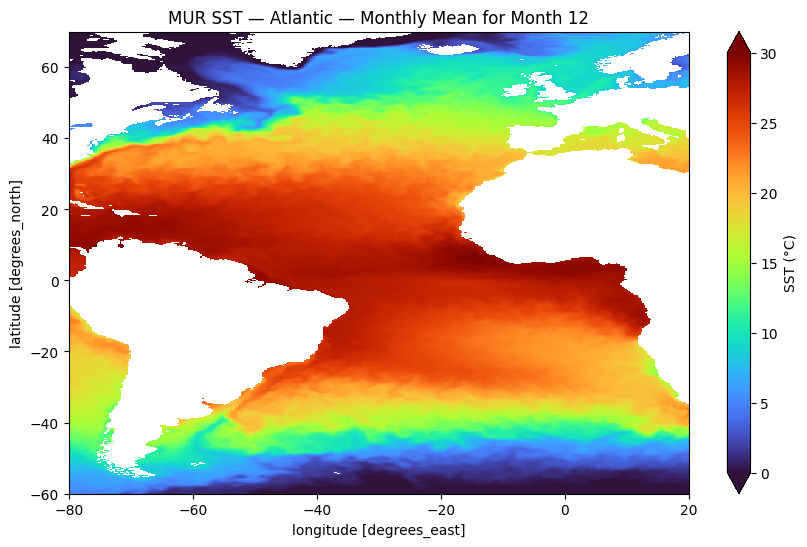

In [20]:
#Monthly mean composites
ds = xr.open_mfdataset(
    ghrsst,
    engine="h5netcdf",
    combine="by_coords",
    drop_variables=["mask", "sea_ice_fraction", "dt_1km_data", "sst_anomaly", "analysis_error"]
)

# Compute SST in Atlantic region and convert from Kelvin to Celsius
sst = ds['analysed_sst'].sel(lat=slice(-60, 70), lon=slice(-80, 20)) - 273.15

monthly_mean = sst.groupby('time.month').mean(dim='time', skipna=True)

# Plot monthly composites
for month in monthly_mean['month'].values:
    fig = plt.figure(figsize=(10, 6))
    monthly_mean.sel(month=month).plot(
        cmap="turbo",
        vmin=0, vmax=30,
        cbar_kwargs={'label': 'SST (°C)'}
    )
    plt.title(f"MUR SST — Atlantic — Monthly Mean for Month {month:02d}")
    plt.show()